# Analysis of experiments
In this notebook we present a simple routine to examine reactivities at varying concentration of SHAPE reagent.
In particular we focus on the different behaviour between nucleotides in GNRA tetraloops and the other nucleotides.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import RNA
import subprocess as sp

##  Extraction and fitting of in-house experimental data.
The in-house data we used for the manuscript are available in the Github repository (file "SHAPE_data_cooperativity_series-2.xlsx").

In [2]:
def intersect(x,y):
    out = []
    for i in range(len(x)):
        for j in range(len(y)):
            if x[i]==y[j]:
                out.append(x[i])
    return out

def fun(x,a,b):
    return a*x+b

import regex
from scipy.optimize import curve_fit
from scipy.stats import dirichlet

slope = []
inter = []
slope1 = []
inter1 = []
all_loop = []
all_stem = []
for name in ['2N2O', '2GIS', '2L1V', '1SCL', '1KXK', '1CQ5', '2GV4']:
    ## Read data-sheet and build sequence
    df = pd.read_excel('SHAPE_data_cooperativity_series-2.xlsx', sheet_name=name, engine='openpyxl', skiprows=1)
    print(name)
    i0 = 0
    for s in df.seqRNA.values:
        if s not in ['A','U','C','G']:
            i0 += 1
        else:
            break
    ntlist = ''.join([s for s in df.seqRNA.values if s in ['A','U','C','G']])
    seq_exp = ''.join(ntlist)
    
    ## Download pdb and build secondary structure with baRNAba
    sp.call(["rm","-rf","{}.pdb".format(name)])
    sp.call(["wget","https://files.rcsb.org/download/{}.pdb".format(name)])
    sp.call(["barnaba","ANNOTATE","--pdb","{}.pdb".format(name),"--dotbracket"])
    with open("outfile.ANNOTATE.dotbracket.out", "r") as f:
        data = f.readlines()
        for l in data:
            ll=l.split()
            if ll[1]=="SEQ": 
                print(ll[2])
                seq_pdb = ll[2]
            if ll[0]==("{}.pdb".format(name)): 
                print(ll[1])
                stru_pdb = ll[1]
                
    ## Align structure to sequence used in experiments
    a = seq_pdb
    b = seq_exp
    search = [(i, i+len(b)) for i in range(len(a)-len(b)+1) if a[i:i+len(b)] == b]
    stru = stru_pdb[search[0][0]:search[0][1]]

    ## Find GNRA tetraloop locations
    stru_loop = [m.start() for m in regex.finditer('\.\.\.\.', stru, overlapped=True)]
    seq_loop = [m.start() for m in regex.finditer('GAAA|GAGA|GUAA|GUGA|GCAA|GCGA|GGAA|GGGA', seq_exp, overlapped=True)]
    startloop = intersect(seq_loop,stru_loop)
    conc = [0.032,0.065,0.125]
    print([seq_exp[i:i+4] for i in startloop])

    ## Extract reactivities of 
    print([stru[i:i+4] for i in startloop])
    if startloop:
        react = np.array([df['areaRX'],df['areaRX.1'],df['areaRX.2']])
        react = np.array([react[i]*conc[i]/np.mean(react[i]) for i in range(3)])
        nn = np.zeros((len(df['areaRX.2'].values)-4*len(startloop),3))
        jj = 0
        kk = 0
        ## Fit reactivities of GNRA tetraloop nucleotides
        for (ii,index) in enumerate(startloop):
            nn[kk:kk+i0+index-jj,:] = react[:,jj:i0+index].T
            kk = len(react[0,jj:i0+index])
            jj = i0+index+4
            rr = np.zeros((4,3))
            nvalid = 0
            for i in range(4):
                if i0+index+i < len(ntlist):
                    rr[i][:] = react[:,i0+index+i]
                    if rr[i].all() > 0.0:
                        all_loop.append(np.log(rr[i]/conc))
                        popt,pcov = curve_fit(fun,np.log(conc),np.log(rr[i]/conc))
                        slope.append(popt[0])
                        inter.append(popt[1])
                        nvalid += 1
        ## Fit reactivities of all the other nucleotides
        for i in range(nn.shape[0]):
            if nn[i].all() > 0:
                all_stem.append(nn[i])
                popt,pcov = curve_fit(fun,np.log(conc),np.log(nn[i]/conc))
                slope1.append(popt[0])
                inter1.append(popt[1])

2N2O
GCAUGUUUUCUGUGAAAACGGUU
....((((((...))))))....
[]
[]
2GIS
GGCUUAUCAAGAGAGGUGGAGGGACUGGCCCGAUGAAACCCGGCAACCAGAAAUGGUGCCAAUUCCUGCAGCGGAAACGUUGAAAGAUGAGCCA
((((.(((....(.(((...(((.[.[[)))......))))(((..(((....))).)))...(]].]((.((....)).))..)))).)))).
['GAAA', 'GAAA']
['....', '....']
2L1V
GGAGAGGUUCUAGUUAUACCCUCUAUAAAAAACUAA
..(((((...[[[......)))))........]]].
[]
[]
1SCL
GGGUGCUCAGUACGAGAGGAACCGCACCC
((((((......(....).....))))))
['GAGA']
['....']
1KXK
GUCUACCUAUCGGGCUAAGGAGCCGUAUGCGAUGAAAGUCGCACGUACGGUUCUAUGCCCGGGGGAAAAC
.....((...(((((....((..(((..((((......))))....)))..))...))))).))......
['GAAA', 'GAAA']
['....', '....']
1CQ5
GGCGUUUACCAGGUCAGGUCCGGAAGGAAGCAGCCAAGGCGCC
((((.......((.....(((....))).....))....))))
['GGAA']
['....']
2GV4
GGACCUCUCGAAAGAGUGGUCC
..(.(..(......)..).)..
['GAAA']
['....']


## Plotting fit results

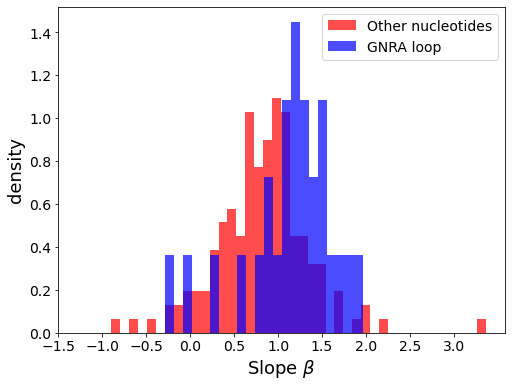

In [3]:
x = np.ones(len(slope))+slope
x1 = np.ones(len(slope1))+slope1
plt.figure(figsize=(8,6))
plt.hist(x1, color = 'red', bins=int((np.max(x1)-np.min(x1))/0.1),alpha=0.7, density=True, label='Other nucleotides')
plt.hist(x, color = 'blue', bins=int((np.max(x)-np.min(x))/0.1),alpha=0.7, density=True, label='GNRA loop')
plt.xlabel(r'Slope $\beta$', fontsize=18)
plt.ylabel(r'density', fontsize=18)
plt.xticks(np.arange(-1.5,3.5,0.5),fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig("/Users/ncalonac/Documents/GitHub/paper-shapemd/Figures/slopes_distr.png", dpi=300)